In [1]:
%matplotlib inline
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [2]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import numpy as np
np.random.seed(0)
import torch.utils.data as data_utils #maybe do this to clean up


In [12]:
model_name = "alexnet"
num_classes = 10 # classes in mnist
feature_extract = False
batch_size_train = 16
batch_size_test = 16
num_epochs = 200

learning_rate = 0.001
momentum = 0.9
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)
device = torch.device("cuda")

# Download Dataset

In [4]:
preprocessing = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

indices = torch.arange(1000)

# MNIST Train Dataset
dataset_train  = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=preprocessing)
random_train_targets = np.random.randint(10, size = dataset_train.targets.shape )

dataset_train_random = copy.deepcopy(dataset_train)
dataset_train_random.targets = random_train_targets

dataset_train = torch.utils.data.Subset(dataset_train, indices)
dataset_train_random = torch.utils.data.Subset(dataset_train_random, indices)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True)
train_loader_random = torch.utils.data.DataLoader(dataset_train_random, batch_size=batch_size_train, shuffle=True)

# MNIST Test Dataset
dataset_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=preprocessing)

ataset_test = torch.utils.data.Subset(dataset_test, indices)

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test, shuffle=True)


'''
this part of code, modified to work ith test loop as per:
This code is based upon the Pytorch Example:
  https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
Citation:
  Inkawhich, N. (2021). Finetuning Torchvision Models — PyTorch Tutorials 1.2.0 documentation. Pytorch.org. Retrieved 19 April 2021, from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html.

'''


# Create training and validation datasets
image_datasets = {'train': dataset_train, 'val':dataset_test}
image_datasets_random = {'train': dataset_train_random, 'val':dataset_test}

# Create training and validation dataloaders
dataloaders_dict = {'train': train_loader, 'val':test_loader}
dataloaders_dict_random = {'train': train_loader_random, 'val':test_loader}

Failed to download (trying next):
HTTP Error 503: Service Unavailable



KeyboardInterrupt: ignored

In [ ]:
for data, target in dataset_train_random:
  print(target, end="  ")
print("\n)")
for data, target in dataset_train:
  print(target, end="  ")

5  0  3  3  7  9  3  5  2  4  7  6  8  8  1  6  7  7  8  1  5  9  8  9  4  3  0  3  5  0  2  3  8  1  3  3  3  7  0  1  9  9  0  4  7  3  2  7  2  0  0  4  5  5  6  8  4  1  4  9  8  1  1  7  9  9  3  6  7  2  0  3  5  9  4  4  6  4  4  3  4  4  8  4  3  7  5  5  0  1  5  9  3  0  5  0  1  2  4  2  0  3  2  0  7  5  9  0  2  7  2  9  2  3  3  2  3  4  1  2  9  1  4  6  8  2  3  0  0  6  0  6  3  3  8  8  8  2  3  2  0  8  8  3  8  2  8  4  3  0  4  3  6  9  8  0  8  5  9  0  9  6  5  3  1  8  0  4  9  6  5  7  8  8  9  2  8  6  6  9  1  6  8  8  3  2  3  6  3  6  5  7  0  8  4  6  5  8  2  3  9  7  5  3  4  5  3  3  7  9  9  9  7  3  2  3  9  7  7  5  1  2  2  8  1  5  8  4  0  2  5  5  0  8  1  1  0  3  8  8  4  4  0  9  3  7  3  2  1  1  2  1  4  2  5  5  5  2  5  7  7  6  1  6  7  2  3  1  9  5  9  9  2  0  9  1  9  0  6  0  4  8  4  3  3  8  8  7  0  3  8  7  7  1  8  4  7  0  4  9  0  6  4  2  4  6  3  3  7  8  5  0  8  5  4  7  4  1  3  3  9  2  5  2  3  5  7  2  7  1  6  5  0  0

# Prebuilts for training

In [13]:
'''
This code is based upon the Pytorch Example:
  https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
Citation:
  Inkawhich, N. (2021). Finetuning Torchvision Models — PyTorch Tutorials 1.2.0 documentation. Pytorch.org. Retrieved 19 April 2021, from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html.

Training loop and imports import function modified for appliocation:
-- needed loop to train instead of finetune
-- needed to adjust model sizes and hyperparameters
-- note data imports also adjusted to fit with this loop
'''


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if epoch_acc > 0.95:
              time_elapsed = time.time() - since
              print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
              print('Best val Acc: {:4f}'.format(best_acc))

              # load best model weights
              model.load_state_dict(best_model_wts)
              return model, val_acc_history

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_exrtact = False, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.features[0] = nn.Conv2d(3, 128, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        model_ft.features[3] = nn.Conv2d(128, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        model_ft.features[6] = nn.Conv2d(384, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        model_ft.features[8] = nn.Conv2d(480, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        model_ft.features[10] =  nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        model_ft.classifier[1] = nn.Linear(in_features=9216, out_features=8192, bias=True)
        model_ft.classifier[4] = nn.Linear(in_features=8192, out_features=4096, bias=True)
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 64

    elif model_name == "vgg":
        """ VGG11
        """
        model_ft = models.vgg11(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 64 #224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

In [15]:
model_ft, input_size = initialize_model("vgg", num_classes, use_pretrained=False)
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

# Training


In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, use_pretrained=False)
model_ft = model_ft.to(device)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/199
----------
train Loss: 2.3027 Acc: 0.1040
val Loss: 2.3017 Acc: 0.1142

Epoch 1/199
----------
train Loss: 2.3013 Acc: 0.1330
val Loss: 2.3010 Acc: 0.1757

Epoch 2/199
----------
train Loss: 2.3005 Acc: 0.1330
val Loss: 2.3005 Acc: 0.1218

Epoch 3/199
----------
train Loss: 2.2989 Acc: 0.1200
val Loss: 2.2997 Acc: 0.1031

Epoch 4/199
----------
train Loss: 2.2982 Acc: 0.1190
val Loss: 2.2988 Acc: 0.1028

Epoch 5/199
----------
train Loss: 2.2972 Acc: 0.1180
val Loss: 2.2979 Acc: 0.1031

Epoch 6/199
----------
train Loss: 2.2955 Acc: 0.1170
val Loss: 2.2965 Acc: 0.1028

Epoch 7/199
----------
train Loss: 2.2939 Acc: 0.1170
val Loss: 2.2945 Acc: 0.1028

Epoch 8/199
----------
train Loss: 2.2915 Acc: 0.1170
val Loss: 2.2914 Acc: 0.1028

Epoch 9/199
----------
train Loss: 2.2880 Acc: 0.1170
val Loss: 2.2868 Acc: 0.1028

Epoch 10/199
----------
train Loss: 2.2821 Acc: 0.1170
val Loss: 2.2784 Acc: 0.1028

Epoch 11/199
----------
train Loss: 2.2716 Acc: 0.1170
val Loss: 2.2639 Acc

In [ ]:
model_ft_random, input_size_random = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
model_ft_random = model_ft_random.to(device)
random_optimizer = optim.SGD(model_ft_random.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft_random, hist_rand = train_model(model_ft_random, dataloaders_dict_random, criterion, random_optimizer, num_epochs=250)

Epoch 0/249
----------
train Loss: 2.3031 Acc: 0.0760
val Loss: 2.3024 Acc: 0.1019

Epoch 1/249
----------
train Loss: 2.3020 Acc: 0.1230
val Loss: 2.3025 Acc: 0.1010

Epoch 2/249
----------
train Loss: 2.3015 Acc: 0.1220
val Loss: 2.3026 Acc: 0.1010

Epoch 3/249
----------
train Loss: 2.3013 Acc: 0.1220
val Loss: 2.3029 Acc: 0.1010

Epoch 4/249
----------
train Loss: 2.3008 Acc: 0.1220
val Loss: 2.3031 Acc: 0.1010

Epoch 5/249
----------
train Loss: 2.3004 Acc: 0.1220
val Loss: 2.3033 Acc: 0.1010

Epoch 6/249
----------
train Loss: 2.3004 Acc: 0.1220
val Loss: 2.3034 Acc: 0.1010

Epoch 7/249
----------
train Loss: 2.3003 Acc: 0.1220
val Loss: 2.3038 Acc: 0.1010

Epoch 8/249
----------
train Loss: 2.3001 Acc: 0.1220
val Loss: 2.3040 Acc: 0.1010

Epoch 9/249
----------
train Loss: 2.3003 Acc: 0.1220
val Loss: 2.3041 Acc: 0.1010

Epoch 10/249
----------
train Loss: 2.2995 Acc: 0.1220
val Loss: 2.3044 Acc: 0.1010

Epoch 11/249
----------
train Loss: 2.2999 Acc: 0.1220
val Loss: 2.3044 Acc

# Spearman rank correlation code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model_ft, "/content/drive/MyDrive/Colab Notebooks/Project/model_alex.pth")
torch.save(model_ft_random, "/content/drive/MyDrive/Colab Notebooks/Project/model_rand_alex.pth")

In [ ]:
model_ft = torch.load("/content/drive/MyDrive/Colab Notebooks/Project/model_alex.pth", map_location=torch.device('cpu'))
model_ft_random = torch.load( "/content/drive/MyDrive/Colab Notebooks/Project/model_rand_alex.pth", map_location=torch.device('cpu'))

In [ ]:
def spearman_rank_corr(a, b):
    lin_a = a.reshape(-1)#convert iage to linear array for easier processing
    indices_a = lin_a.argsort()
    rank_a = torch.zeros_like(indices_a)
    rank_a[indices_a] = torch.arange(len(lin_a))

    lin_b = b.reshape(-1)
    indices_b = lin_b.argsort()
    rank_b = torch.zeros_like(indices_b)
    rank_b[indices_b] = torch.arange(len(lin_b))

    N = lin_a.size(0)
    num = torch.sum((rank_a - rank_b).pow(2))
    den = N*(N**2-1.0)#need to write like this for numerics, n^3 somestimes caused issues
    return 1.0 - ((6*num)/den)


# SmoothGrad code

In [ ]:
def calcImageGrad(image, model):
  model.eval()
  image.requires_grad_()
  output = model(image)
  class_ind = output.argmax()
  #print(class_ind)
  grad = output[0, class_ind]
  #print(grad)
  grad.backward()
  return torch.max(image.grad.data.abs(), dim=1)[0]

  
def smoothGrad(stdev, n, input, model):
  grad_stdev = float((stdev/100)*(torch.max(input[0])-torch.min(input[0])))
  #print("standard dev: ", grad_stdev)
  total =  torch.from_numpy(np.zeros(input.shape))
  image_tensor = input

  for i in range(n):
    #print_progress(i,n)
    size = input.shape
    input_image = (image_tensor.detach() + np.random.normal(0,grad_stdev, size = size)).float()
    input_image.requires_grad_()
    image_grad = calcImageGrad(input_image, model)
    #print(image_grad.shape)
    #print(total.shape)
    total = total+image_grad
  return (total/n)

In [ ]:
import torch
import torchvision
from torchvision import models
from torchvision import transforms
from torch import nn
import cv2
import numpy as np
import os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from PIL import Image
import random

def gradCAM(img, model, guided=False, cnn_layer_idx=None, class_idx=None, transform=None, save_heatmap=None, print_cls=False, print_pred=False):
    '''
    PARAMETERS
      img           : image for which grad-CAM will be plotted
      model         : model for which grad-CAM will be plotted
      cnn_layer_idx : (int) grad-CAM will be plotted with the result of this i-th 
                      convolutional layer of the model
      class_idx     : (int) idx of the class for which grad-CAM will be plotted
                      If None, the default predicted class will be used. 
    '''

    output = img

    cnn_i, sequential_i = 0, 0
    cnn_weights = []
    for module_i, module in enumerate(list(model.modules())[1:]):    
      if isinstance(module, torch.nn.modules.container.Sequential):
        continue
      else:       
        try:
          output = module(output)
          if isinstance(module, torch.nn.modules.pooling.AdaptiveAvgPool2d) :
            output = torch.flatten(output, 1)
        except Exception as e:
          print(module_i, module)
        if isinstance(module, torch.nn.modules.conv.Conv2d):
          cnn_weights.append(output)

    ### Step 1 ###
    # gradient of class c score (BEFORE softmax), wrt CNN feature map activations "layer weights"
    if class_idx is None:
      class_idx = torch.argmax(output, dim=-1).item()
    if print_cls:
      print("class:({})".format(class_idx), imagenet_labels[class_idx])
    #predicted
    cls_idx = torch.argmax(output, dim=-1)  
    if print_pred:
      print("predicted class:({})".format(cls_idx.item()), imagenet_labels[cls_idx.item()])
    grads = torch.autograd.grad(output[0, class_idx], cnn_weights[-1], retain_graph=True)
    grads = grads[0].squeeze(0)  # [n_filtermap, W_lastCNN, H_lastCNN]
    if guided:
      # Target for backprop
      one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
      one_hot_output[0][class_idx] = 1
      grads_guided = torch.autograd.grad(one_hot_output, img, retain_graph=True)
      grads_guided = grads_guided[0].squeeze(0)
      # Backward pass
      #output.backward(gradient=one_hot_output)
      # Convert Pytorch variable to numpy array
      # [0] to get rid of the first channel (1,3,224,224)
      #gradients_as_arr = self.gradients.data.numpy()[0]
      grads_guided = torch.clamp(grads_guided, min=0.).detach().numpy()

    ### Step 2 ###
    grads_avgpooled = torch.mean(grads, axis=(1,2))  # [n_filtermap] 
    grads_avgpooled = grads_avgpooled.expand_as(cnn_weights[-1].squeeze(0).permute(1,2,0))
    grads_avgpooled = grads_avgpooled.permute(2,0,1)

    ### Step 3 : ReLU of Linear Combination ###
    
    map = nn.ReLU()(grads_avgpooled*cnn_weights[-1].squeeze(0))   # layer_weights shape
    map = torch.sum(map, dim=0)  # [W_lastCNN, H_lastCNN]
    map_interpolated = np.array(cv2.resize(map.detach().numpy(), dsize=img.shape[2:], interpolation=cv2.INTER_CUBIC))

    if guided:
      guided_map = map_interpolated*grads_guided
      plt.imshow(guided_map.transpose(1,2,0))
      plt.show()

    ### Step 4 ###
    map_interpolated = cv2.resize(map.detach().numpy(), dsize=img.shape[2:], interpolation=cv2.INTER_CUBIC)
    # make color heatmap
    heatmap = cv2.normalize(map_interpolated, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # overlay heatmap on top of the image
    fin = heatmap

    return class_idx, fin[:,:,::-1]

In [ ]:
data, label = dataset_train[0]
data = data.unsqueeze(0)
print(data.shape)
data = data.to("cpu")

torch.Size([1, 3, 64, 64])


In [ ]:
model_ft.eval()
model_ft.to("cpu")
output = model_ft(data)

7


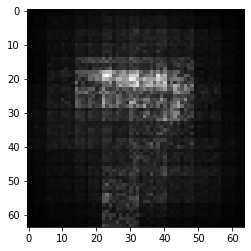

In [ ]:
i=0
model_ft.eval()
model_ft = model_ft.to("cpu")
for data, label in dataset_test:
  data = data.unsqueeze(0)
  data = data.to("cpu")
  saliency1 = smoothGrad(20, 20, data, model_ft)
  plt.imshow(saliency1.squeeze(0)[0], cmap=plt.cm.gray)
  print(label)
  break
  
  

7


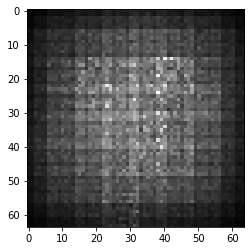

In [ ]:
model_ft_random.eval()
model_ft_random = model_ft_random.to("cpu")
for data, label in dataset_test:
  data = data.unsqueeze(0)
  data = data.to("cpu")
  saliency2 = smoothGrad(20, 20, data, model_ft_random)
  plt.imshow(saliency2.squeeze(0)[0], cmap=plt.cm.gray)
  print(label)
  break
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


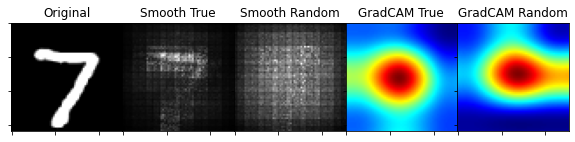

In [ ]:
for data, label in dataset_test:
  data = data.unsqueeze(0)
  data = data.to("cpu")
  saliency_smooth_true = smoothGrad(20, 20, data, model_ft)
  _, saliency_gradcam_true = gradCAM(data, model_ft, class_idx=label, cnn_layer_idx=0)
  saliency_smooth_rand = smoothGrad(20, 20, data, model_ft_random)
  _, saliency_gradcam_rand = gradCAM(data, model_ft_random, class_idx=label, cnn_layer_idx=0)
  break
fig, ax = plt.subplots(1,5) 
ax[0].imshow(data.squeeze(0).permute(1,2,0))    
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_aspect("auto")
ax[0].set_title("Original")
ax[1].imshow(saliency_smooth_true.squeeze(0)[0], cmap=plt.cm.gray)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_aspect("auto")
ax[1].set_title("Smooth True")
ax[3].imshow(torch.from_numpy(np.flip(saliency_gradcam_true,axis=0).copy()), cmap=plt.cm.gray)
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])
ax[3].set_aspect("auto")
ax[3].set_title("GradCAM True")
ax[2].imshow(saliency_smooth_rand.squeeze(0)[0], cmap=plt.cm.gray)
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_aspect("auto")
ax[2].set_title("Smooth Random")
ax[4].imshow(torch.from_numpy(np.flip(saliency_gradcam_rand,axis=0).copy()), cmap=plt.cm.gray)
ax[4].set_xticklabels([])
ax[4].set_yticklabels([])
ax[4].set_aspect("auto")
ax[4].set_title("GradCAM Random")

fig.subplots_adjust(wspace=0, hspace = 0)
fig.set_size_inches(10,2)
fig.savefig("/content/drive/MyDrive/Colab Notebooks/Project/output_images/MNIST_alexnet.jpg")

In [ ]:
spearman_smoothgrad = np.array([])
i=0
for data, label in dataset_test:
  i+=1
  if i == 100:
    break
  print(i,"/1000")
  data = data.unsqueeze(0)
  data = data.to("cpu")
  saliency_true = smoothGrad(20, 20, data, model_ft)
  saliency_random = smoothGrad(20, 20, data, model_ft_random)
  spearman_smoothgrad = np.append(spearman_smoothgrad,spearman_rank_corr(saliency_true.squeeze(0)[0],  saliency_random.squeeze(0)[0]))



In [ ]:
spearman_smoothgrad

array([0.87087512, 0.8049413 , 0.93383873, 0.87541074, 0.85729355,
       0.92733234, 0.86317754, 0.88128096, 0.88953507, 0.88113737,
       0.84979469, 0.81641966, 0.90674126, 0.83000487, 0.91553837,
       0.88574278, 0.89288825, 0.86472178, 0.86785913, 0.89570868,
       0.85617077, 0.85509127, 0.87861359, 0.89623231, 0.88057303,
       0.85215956, 0.87686718, 0.85981357, 0.83422405, 0.91033971,
       0.82704502, 0.92119181, 0.83497411, 0.79841685, 0.86205482,
       0.83774257, 0.86899078, 0.92072964, 0.87869877, 0.89833832,
       0.9170953 , 0.88412309, 0.85945612, 0.81954008, 0.84405243,
       0.90461236, 0.88592118, 0.81344318, 0.85159403, 0.84433413,
       0.85983002, 0.82085574, 0.90082842, 0.88567519, 0.82903242,
       0.86807853, 0.84165478, 0.92425764, 0.88905424, 0.8566798 ,
       0.81749868, 0.86858302, 0.86428595, 0.88858092, 0.85283184,
       0.87880296, 0.83041811, 0.84186161, 0.86846691, 0.86366147,
       0.85421956, 0.86619061, 0.81028867, 0.87231708, 0.90340

array([0.87087512, 0.8049413 , 0.93383873, 0.87541074, 0.85729355,
       0.92733234, 0.86317754, 0.88128096, 0.88953507, 0.88113737,
       0.84979469, 0.81641966, 0.90674126, 0.83000487, 0.91553837,
       0.88574278, 0.89288825, 0.86472178, 0.86785913, 0.89570868,
       0.85617077, 0.85509127, 0.87861359, 0.89623231, 0.88057303,
       0.85215956, 0.87686718, 0.85981357, 0.83422405, 0.91033971,
       0.82704502, 0.92119181, 0.83497411, 0.79841685, 0.86205482,
       0.83774257, 0.86899078, 0.92072964, 0.87869877, 0.89833832,
       0.9170953 , 0.88412309, 0.85945612, 0.81954008, 0.84405243,
       0.90461236, 0.88592118, 0.81344318, 0.85159403, 0.84433413,
       0.85983002, 0.82085574, 0.90082842, 0.88567519, 0.82903242,
       0.86807853, 0.84165478, 0.92425764, 0.88905424, 0.8566798 ,
       0.81749868, 0.86858302, 0.86428595, 0.88858092, 0.85283184,
       0.87880296, 0.83041811, 0.84186161, 0.86846691, 0.86366147,
       0.85421956, 0.86619061, 0.81028867, 0.87231708, 0.90340185,
       0.80281377, 0.82256663, 0.86954546, 0.85386962, 0.82623047,
       0.85948819, 0.85608166, 0.86043978, 0.85686171, 0.85898113,
       0.84502691, 0.84621823, 0.84018046, 0.86670226, 0.91916597,
       0.85889381, 0.86976159, 0.88357979, 0.82843995, 0.88658142,
       0.78888154, 0.91687042, 0.86421716, 0.81222457])

In [ ]:
'''
for data, label in dataset_train:
  data = data.unsqueeze(0)
  data = data.to("cpu")
  _, h = gradCAM(data, model_ft, class_idx=label, cnn_layer_idx=0)
  print(h.shape)
  print(h)
  break'''
  
spearman_gradCAM = np.array([])
i=0
for data, label in dataset_train:
  i+=1
  if i == 100:
    break
  print(i,"/1000")
  data = data.unsqueeze(0)
  data = data.to("cpu")
  _, saliency_true = gradCAM(data, model_ft, class_idx=label, cnn_layer_idx=0)
  saliency_true = torch.from_numpy(np.flip(saliency_true,axis=0).copy())
  _, saliency_random = gradCAM(data, model_ft_random, class_idx=label, cnn_layer_idx=0)
  saliency_random = torch.from_numpy(np.flip(saliency_random,axis=0).copy())
  spearman_gradCAM = np.append(spearman_gradCAM,spearman_rank_corr(saliency_true,  saliency_random))



In [ ]:
spearman_gradCAM

array([ 0.56687558,  0.40337217,  0.36848843,  0.20008343,  0.18425477,
        0.27878445,  0.27720493,  0.11453718,  0.41034847,  0.74959552,
        0.04500049,  0.28760183,  0.15013862,  0.7003541 ,  0.4325031 ,
        0.10338569,  0.53805518,  0.49051136,  0.47425008,  0.30330074,
        0.61888617,  0.2901271 ,  0.17852658,  0.32335395, -0.03056896,
        0.24471462,  0.60110784,  0.18616301,  0.30719447,  0.48910594,
        0.36392695,  0.60443258,  0.5816763 ,  0.06310034,  0.64888549,
        0.60128558,  0.52936852,  0.67875946,  0.4547388 ,  0.60432279,
        0.41465694,  0.53682947,  0.2193082 ,  0.12041444,  0.16931105,
        0.28320879,  0.54393744,  0.59049857,  0.48217839,  0.07002932,
       -0.1385535 ,  0.30175108,  0.60172105,  0.41208375,  0.34274328,
        0.58039623,  0.41415226,  0.21348351,  0.73404396,  0.31186038,
        0.61234117,  0.62135625,  0.5569762 ,  0.58447254,  0.53789991,
        0.36176103,  0.61281621,  0.46930248,  0.55360913,  0.19

array([ 0.56687558,  0.40337217,  0.36848843,  0.20008343,  0.18425477,
        0.27878445,  0.27720493,  0.11453718,  0.41034847,  0.74959552,
        0.04500049,  0.28760183,  0.15013862,  0.7003541 ,  0.4325031 ,
        0.10338569,  0.53805518,  0.49051136,  0.47425008,  0.30330074,
        0.61888617,  0.2901271 ,  0.17852658,  0.32335395, -0.03056896,
        0.24471462,  0.60110784,  0.18616301,  0.30719447,  0.48910594,
        0.36392695,  0.60443258,  0.5816763 ,  0.06310034,  0.64888549,
        0.60128558,  0.52936852,  0.67875946,  0.4547388 ,  0.60432279,
        0.41465694,  0.53682947,  0.2193082 ,  0.12041444,  0.16931105,
        0.28320879,  0.54393744,  0.59049857,  0.48217839,  0.07002932,
       -0.1385535 ,  0.30175108,  0.60172105,  0.41208375,  0.34274328,
        0.58039623,  0.41415226,  0.21348351,  0.73404396,  0.31186038,
        0.61234117,  0.62135625,  0.5569762 ,  0.58447254,  0.53789991,
        0.36176103,  0.61281621,  0.46930248,  0.55360913,  0.19603997,
        0.34149706,  0.54139841,  0.39934278,  0.58239007, -0.094998  ,
        0.18712962,  0.00474662,  0.26412809,  0.62852824,  0.42140895,
        0.11026388,  0.00099397,  0.36429787,  0.5126524 ,  0.45789099,
        0.60350907,  0.22925788,  0.36174959,  0.56285131,  0.64260596,
        0.67282164,  0.41467613,  0.49547738,  0.59034181,  0.53444695,
        0.40668309,  0.18620342,  0.55527872,  0.01360947])

#Next steps
finish with the other model

potential issues


1.   upscaling images ->as seen in the saliency maps
2.   use of aleznet/ vggc for deep models _. not tailored construction on the networks




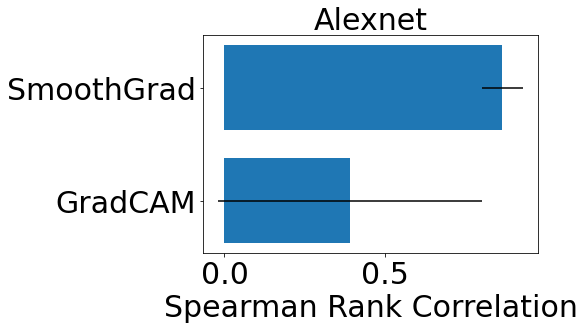

In [ ]:
spearman_smoothgrad = np.array([0.87087512, 0.8049413 , 0.93383873, 0.87541074, 0.85729355, 0.92733234, 0.86317754, 0.88128096, 0.88953507, 0.88113737, 0.84979469, 0.81641966, 0.90674126, 0.83000487, 0.91553837, 0.88574278, 0.89288825, 0.86472178, 0.86785913, 0.89570868, 0.85617077, 0.85509127, 0.87861359, 0.89623231, 0.88057303, 0.85215956, 0.87686718, 0.85981357, 0.83422405, 0.91033971, 0.82704502, 0.92119181, 0.83497411, 0.79841685, 0.86205482, 0.83774257, 0.86899078, 0.92072964, 0.87869877, 0.89833832, 0.9170953 , 0.88412309, 0.85945612, 0.81954008, 0.84405243, 0.90461236, 0.88592118, 0.81344318, 0.85159403, 0.84433413, 0.85983002, 0.82085574, 0.90082842, 0.88567519, 0.82903242, 0.86807853, 0.84165478, 0.92425764, 0.88905424, 0.8566798 , 0.81749868, 0.86858302, 0.86428595, 0.88858092, 0.85283184, 0.87880296, 0.83041811, 0.84186161, 0.86846691, 0.86366147, 0.85421956, 0.86619061, 0.81028867, 0.87231708, 0.90340185, 0.80281377, 0.82256663, 0.86954546, 0.85386962, 0.82623047, 0.85948819, 0.85608166, 0.86043978, 0.85686171, 0.85898113, 0.84502691, 0.84621823, 0.84018046, 0.86670226, 0.91916597, 0.85889381, 0.86976159, 0.88357979, 0.82843995, 0.88658142, 0.78888154, 0.91687042, 0.86421716, 0.81222457])
spearman_gradCAM = np.array([ 0.56687558, 0.40337217, 0.36848843, 0.20008343, 0.18425477, 0.27878445, 0.27720493, 0.11453718, 0.41034847, 0.74959552, 0.04500049, 0.28760183, 0.15013862, 0.7003541 , 0.4325031 , 0.10338569, 0.53805518, 0.49051136, 0.47425008, 0.30330074, 0.61888617, 0.2901271 , 0.17852658, 0.32335395, -0.03056896, 0.24471462, 0.60110784, 0.18616301, 0.30719447, 0.48910594, 0.36392695, 0.60443258, 0.5816763 , 0.06310034, 0.64888549, 0.60128558, 0.52936852, 0.67875946, 0.4547388 , 0.60432279, 0.41465694, 0.53682947, 0.2193082 , 0.12041444, 0.16931105, 0.28320879, 0.54393744, 0.59049857, 0.48217839, 0.07002932, -0.1385535 , 0.30175108, 0.60172105, 0.41208375, 0.34274328, 0.58039623, 0.41415226, 0.21348351, 0.73404396, 0.31186038, 0.61234117, 0.62135625, 0.5569762 , 0.58447254, 0.53789991, 0.36176103, 0.61281621, 0.46930248, 0.55360913, 0.19603997, 0.34149706, 0.54139841, 0.39934278, 0.58239007, -0.094998 , 0.18712962, 0.00474662, 0.26412809, 0.62852824, 0.42140895, 0.11026388, 0.00099397, 0.36429787, 0.5126524 , 0.45789099, 0.60350907, 0.22925788, 0.36174959, 0.56285131, 0.64260596, 0.67282164, 0.41467613, 0.49547738, 0.59034181, 0.53444695, 0.40668309, 0.18620342, 0.55527872, 0.01360947])
spear_smooth_avg = np.mean(spearman_smoothgrad)
spear_smooth_high = 2*np.std(spearman_smoothgrad)
#spear_smooth_low = spear_smooth_avg - 2*np.std(spearman_smoothgrad)

spear_grad_avg = np.mean(spearman_gradCAM)
spear_grad_high = 2*np.std(spearman_gradCAM)
#spear_grad_low = spear_grad_avg - 2*np.std(spearman_gradCAM)

fig, ax = plt.subplots()
ax.barh([0,0.2], [spear_smooth_avg, spear_grad_avg], xerr=[spear_smooth_high, spear_grad_high], align='center', height=0.15)
ax.set_yticks([0,0.2])
ax.set_yticklabels(["SmoothGrad", "GradCAM"],fontsize = 30)
ax.invert_yaxis()
ax.set_xlabel('Spearman Rank Correlation',fontsize = 30)
plt.title("Alexnet",fontsize = 30)
plt.show()
import matplotlib
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

fig.set_size_inches(32,8)
fig.savefig("/content/drive/MyDrive/Colab Notebooks/Project/output_images/alex_rand_labels.jpg")

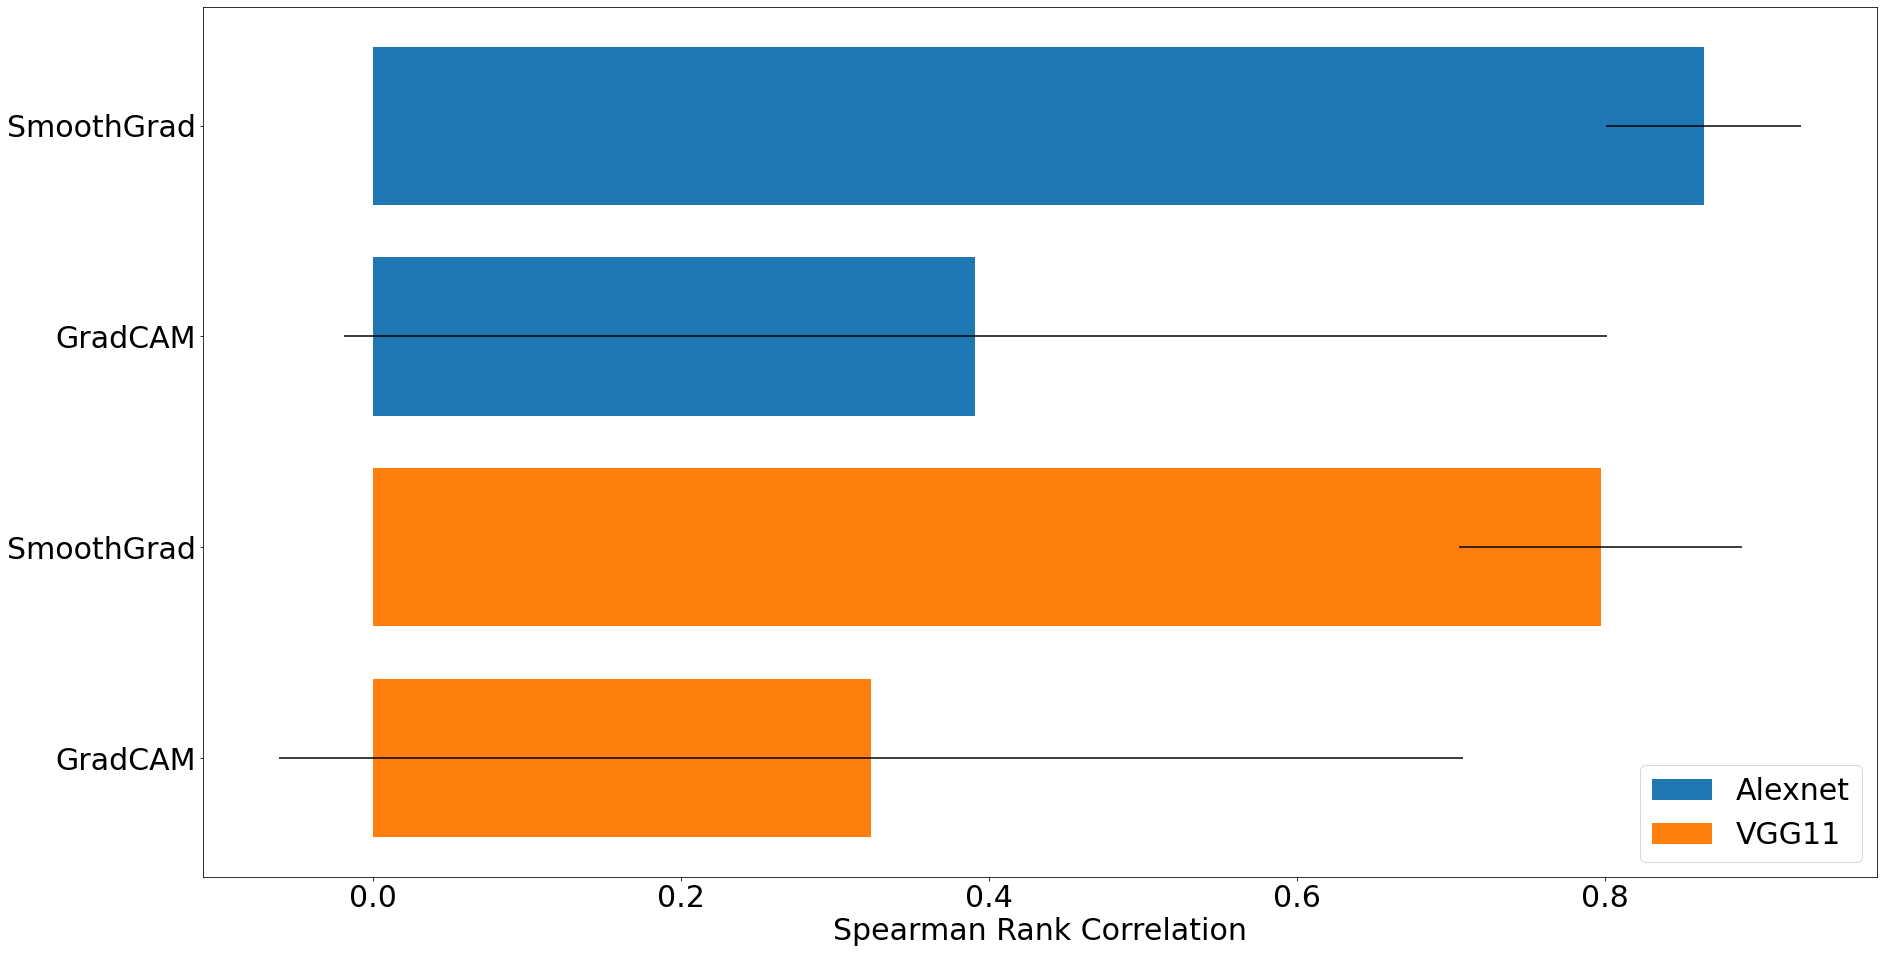

In [ ]:
spearman_smoothgrad_vgg = np.array([0.7993933 , 0.75524271, 0.87460464, 0.75862485, 0.85358685, 
       0.83795309, 0.83065557, 0.81405884, 0.72617179, 0.77249652,
       0.76762837, 0.77383101, 0.84524381, 0.79037201, 0.82258308,
       0.75446254, 0.85012203, 0.78165102, 0.7006495 , 0.85954589,
       0.80119491, 0.78569108, 0.84152764, 0.83255064, 0.85281307,
       0.67054778, 0.81404299, 0.8253082 , 0.76606721, 0.85249794,
       0.79938614, 0.84589887, 0.78052855, 0.80438   , 0.72334069,
       0.7614513 , 0.80109078, 0.84318632, 0.83426082, 0.80575395,
       0.88127458, 0.85904181, 0.8253153 , 0.83404911, 0.80252069,
       0.82803166, 0.80511022, 0.82378018, 0.73481274, 0.79511797,
       0.79061639, 0.74491316, 0.79156613, 0.79380625, 0.75475967,
       0.82041329, 0.76462936, 0.85955614, 0.81361562, 0.8805148 ,
       0.72223401, 0.81975532, 0.87229621, 0.80193257, 0.76508862,
       0.87650466, 0.78488439, 0.7954489 , 0.77768898, 0.7502408 ,
       0.76295984, 0.71292758, 0.75159901, 0.77657551, 0.83663374,
       0.83253253, 0.80174041, 0.8623575 , 0.78674895, 0.69210082,
       0.83734965, 0.76046312, 0.744115  , 0.82785535, 0.82802594,
       0.73735285, 0.76667541, 0.789837  , 0.77321357, 0.81760514,
       0.78843731, 0.77622962, 0.84756964, 0.71086097, 0.78042406,
       0.72552383, 0.87137091, 0.7898742 , 0.74541295])
spearman_gradCAM_vgg = np.array([ 0.15929759,  0.15869564, -0.08452594,  0.48854011,  0.30863982,
       -0.1657995 ,  0.31789696,  0.44119453,  0.36869645,  0.13039476,
        0.34683567,  0.26517057,  0.31118077,  0.49120265,  0.18592668,
        0.00977051,  0.1436851 ,  0.47479522,  0.58888668,  0.24992788,
        0.10717249,  0.19615281,  0.11337513, -0.01352978,  0.47595793,
        0.50458395,  0.21393049,  0.45421314,  0.40990382,  0.53162432,
        0.58025819,  0.43484205,  0.4792617 ,  0.67401433,  0.3421424 ,
        0.19537234,  0.40046108,  0.31887215,  0.24583894,  0.20193166,
        0.08714747,  0.40868747,  0.42125392,  0.262703  ,  0.37268728,
        0.15870595,  0.26220971,  0.19268632,  0.36517036,  0.52123123,
        0.29383969,  0.50023019, -0.11485624,  0.09505421,  0.05283308,
        0.38924754,  0.52238476, -0.15169954,  0.06011057,  0.28152514,
        0.58996713,  0.53434432,  0.33459306,  0.38294929,  0.70634246,
        0.35613054,  0.20328867,  0.37019145,  0.24099642,  0.56830359,
        0.40735406,  0.42836237,  0.41692537,  0.30675668,  0.32461804,
        0.25744981,  0.56669974, -0.02838469,  0.50214911,  0.50577408,
        0.35152406,  0.45568478,  0.44867849,  0.50927794, -0.06110525,
        0.3196798 ,  0.35703611,  0.24368787,  0.12204939, -0.04335916,
        0.61660099,  0.29008472,  0.38709253,  0.55839097,  0.54492545,
        0.35512531,  0.51875913,  0.56803715,  0.47819638])
spear_smooth_avg_vgg = np.mean(spearman_smoothgrad_vgg)
spear_smooth_high_vgg = 2*np.std(spearman_smoothgrad_vgg)
#spear_smooth_low = spear_smooth_avg - 2*np.std(spearman_smoothgrad)

spear_grad_avg_vgg = np.mean(spearman_gradCAM_vgg)
spear_grad_high_vgg = 2*np.std(spearman_gradCAM_vgg)
#spear_grad_low = spear_grad_avg - 2*np.std(spearman_gradCAM)

spearman_smoothgrad_alex = np.array([0.87087512, 0.8049413 , 0.93383873, 0.87541074, 0.85729355, 0.92733234, 0.86317754, 0.88128096, 0.88953507, 0.88113737, 0.84979469, 0.81641966, 0.90674126, 0.83000487, 0.91553837, 0.88574278, 0.89288825, 0.86472178, 0.86785913, 0.89570868, 0.85617077, 0.85509127, 0.87861359, 0.89623231, 0.88057303, 0.85215956, 0.87686718, 0.85981357, 0.83422405, 0.91033971, 0.82704502, 0.92119181, 0.83497411, 0.79841685, 0.86205482, 0.83774257, 0.86899078, 0.92072964, 0.87869877, 0.89833832, 0.9170953 , 0.88412309, 0.85945612, 0.81954008, 0.84405243, 0.90461236, 0.88592118, 0.81344318, 0.85159403, 0.84433413, 0.85983002, 0.82085574, 0.90082842, 0.88567519, 0.82903242, 0.86807853, 0.84165478, 0.92425764, 0.88905424, 0.8566798 , 0.81749868, 0.86858302, 0.86428595, 0.88858092, 0.85283184, 0.87880296, 0.83041811, 0.84186161, 0.86846691, 0.86366147, 0.85421956, 0.86619061, 0.81028867, 0.87231708, 0.90340185, 0.80281377, 0.82256663, 0.86954546, 0.85386962, 0.82623047, 0.85948819, 0.85608166, 0.86043978, 0.85686171, 0.85898113, 0.84502691, 0.84621823, 0.84018046, 0.86670226, 0.91916597, 0.85889381, 0.86976159, 0.88357979, 0.82843995, 0.88658142, 0.78888154, 0.91687042, 0.86421716, 0.81222457])
spearman_gradCAM_alex = np.array([ 0.56687558, 0.40337217, 0.36848843, 0.20008343, 0.18425477, 0.27878445, 0.27720493, 0.11453718, 0.41034847, 0.74959552, 0.04500049, 0.28760183, 0.15013862, 0.7003541 , 0.4325031 , 0.10338569, 0.53805518, 0.49051136, 0.47425008, 0.30330074, 0.61888617, 0.2901271 , 0.17852658, 0.32335395, -0.03056896, 0.24471462, 0.60110784, 0.18616301, 0.30719447, 0.48910594, 0.36392695, 0.60443258, 0.5816763 , 0.06310034, 0.64888549, 0.60128558, 0.52936852, 0.67875946, 0.4547388 , 0.60432279, 0.41465694, 0.53682947, 0.2193082 , 0.12041444, 0.16931105, 0.28320879, 0.54393744, 0.59049857, 0.48217839, 0.07002932, -0.1385535 , 0.30175108, 0.60172105, 0.41208375, 0.34274328, 0.58039623, 0.41415226, 0.21348351, 0.73404396, 0.31186038, 0.61234117, 0.62135625, 0.5569762 , 0.58447254, 0.53789991, 0.36176103, 0.61281621, 0.46930248, 0.55360913, 0.19603997, 0.34149706, 0.54139841, 0.39934278, 0.58239007, -0.094998 , 0.18712962, 0.00474662, 0.26412809, 0.62852824, 0.42140895, 0.11026388, 0.00099397, 0.36429787, 0.5126524 , 0.45789099, 0.60350907, 0.22925788, 0.36174959, 0.56285131, 0.64260596, 0.67282164, 0.41467613, 0.49547738, 0.59034181, 0.53444695, 0.40668309, 0.18620342, 0.55527872, 0.01360947])
spear_smooth_avg_alex = np.mean(spearman_smoothgrad_alex)
spear_smooth_high_alex = 2*np.std(spearman_smoothgrad_alex)
#spear_smooth_low = spear_smooth_avg - 2*np.std(spearman_smoothgrad)

spear_grad_avg_alex = np.mean(spearman_gradCAM_alex)
spear_grad_high_alex = 2*np.std(spearman_gradCAM_alex)
#spear_grad_low = spear_grad_avg - 2*np.std(spearman_gradCAM)

fig, ax = plt.subplots()
ax.barh([0,0.2], [spear_smooth_avg_alex, spear_grad_avg_alex], xerr=[spear_smooth_high_alex, spear_grad_high_alex], align='center', height=0.15)
ax.barh([0.4, 0.6], [spear_smooth_avg_vgg, spear_grad_avg_vgg], xerr=[spear_smooth_high_vgg, spear_grad_high_vgg], align='center', height=0.15)

ax.set_yticks([0,0.2, 0.4, 0.6])
ax.set_yticklabels(["SmoothGrad", "GradCAM", "SmoothGrad","GradCAM"],fontsize = 30)
ax.invert_yaxis()
ax.set_xlabel('Spearman Rank Correlation',fontsize = 30)
#plt.title("Alexnet",fontsize = 30)
import matplotlib
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)
plt.legend(["Alexnet", "VGG11"], prop={'size':30})
fig.set_size_inches(30,16)
fig.savefig("/content/drive/MyDrive/Colab Notebooks/Project/output_images/merged_rand_labels.jpg")
plt.show()
